# TensorFlow Tutorial #13-B
# Visual Analysis (MNIST)

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

Tutorial #13 showed how to find input images that maximized the response of individual neurons inside the Inception model, so as to find the images that the neuron *liked to see*. But because the Inception model is so large and complex the images were just complex wavy patterns.

This tutorial uses a much simpler Convolutional Neural Network with the MNIST data-set for recognizing hand-written digits. The code is spliced together from Tutorial #03-B for constructing the neural network and Tutorial #13 for finding input images that maximize individual neuron responses inside the neural network, so a lot of this code may look familiar to you.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. Note that there are two separate optimization loops here:

First the weights of the neural network are optimized by inputting images and their true classes to the network so as to improve the classification accuracy.

Afterwards a second optimization is performed which finds the input image that maximizes a given feature or neuron inside the network. This finds an image that the network *likes to see*.

![Flowchart](images/13b_visual_analysis_flowchart.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math

/home/magnus/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.9.0'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [5]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

### Helper-functions for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Function used to plot 10 images in a 2x5 grid.

In [7]:
def plot_images10(images, smooth=True):
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 5)

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # For each entry in the grid.
    for i, ax in enumerate(axes.flat):
        # Get the i'th image and only use the desired pixels.
        img = images[i, :, :]
        
        # Plot the image.
        ax.imshow(img, interpolation=interpolation, cmap='binary')

        # Remove ticks.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()    

Function used to plot a single image.

In [8]:
def plot_image(image):
    plt.imshow(image, interpolation='nearest', cmap='binary')
    plt.xticks([])
    plt.yticks([])

### Plot a few images to see if data is correct

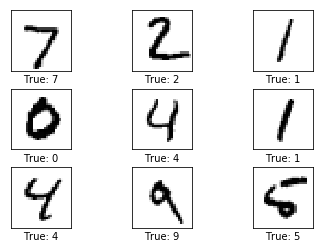

In [9]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The neural network is constructed as a computational graph in TensorFlow using the `tf.layers` API, which is described in detail in Tutorial #03-B.

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-rank tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [11]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [13]:
y_true_cls = tf.argmax(y_true, axis=1)

### Neural Network

We now implement the Convolutional Neural Network using the Layers API. We use the `net`-variable to refer to the last layer while building the neural network. This makes it easy to add or remove layers in the code if you want to experiment. First we set the `net`-variable to the reshaped input image.

In [14]:
net = x_image

The input image is then input to the first convolutional layer, which has 16 filters each of size 5x5 pixels. The activation-function is the Rectified Linear Unit (ReLU) described in more detail in Tutorial #02.

In [15]:
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)

After the convolution we do a max-pooling which is also described in Tutorial #02.

In [16]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

Then we make a second convolutional layer, also with max-pooling.

In [17]:
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

In [18]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

The output then needs to be flattened so it can be used in fully-connected (aka. dense) layers.

In [19]:
net = tf.contrib.layers.flatten(net)

# This should eventually be replaced by:
# net = tf.layers.flatten(net)

We can now add fully-connected (or dense) layers to the neural network.

In [20]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

We need the neural network to classify the input images into 10 different classes. So the final fully-connected layer has `num_classes=10` output neurons.

In [21]:
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

The outputs of the final fully-connected layer are sometimes called logits, so we have a convenience variable with that name which we will also use further below.

In [22]:
logits = net

We use the softmax function to 'squash' the outputs so they are between zero and one, and so they sum to one.

In [23]:
y_pred = tf.nn.softmax(logits=logits)

This tells us how likely the neural network thinks the input image is of each possible class. The one that has the highest value is considered the most likely so its index is taken to be the class-number.

In [24]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Loss-Function to be Optimized

To make the model better at classifying the input images, we must somehow change the variables of the neural network.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the model.

TensorFlow has a function for calculating the cross-entropy, which uses the values of the `logits`-layer because it also calculates the softmax internally, so as to to improve numerical stability.

In [25]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=logits)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [26]:
loss = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the Adam optimizer with a learning-rate of 1e-4.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Classification Accuracy

We need to calculate the classification accuracy so we can report progress to the user.

First we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [28]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [29]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Optimize the Neural Network

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [30]:
session = tf.Session()

### Initialize variables

The variables for the TensorFlow graph must be initialized before we start optimizing them.

In [31]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to do more optimization iterations.

In [32]:
train_batch_size = 64

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [33]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [34]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [35]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Below is a function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [36]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Performance before any optimization

The accuracy on the test-set is very low because the variables for the neural network have only been initialized and not optimized at all, so it just classifies the images randomly.

In [37]:
print_test_accuracy()

Accuracy on Test-Set: 10.3% (1032 / 10000)


### Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [38]:
%%time
optimize(num_iterations=10000)

Optimization Iteration:      1, Training Accuracy:  12.5%
Optimization Iteration:    101, Training Accuracy:  79.7%
Optimization Iteration:    201, Training Accuracy:  92.2%
Optimization Iteration:    301, Training Accuracy:  93.8%
Optimization Iteration:    401, Training Accuracy:  90.6%
Optimization Iteration:    501, Training Accuracy:  96.9%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  90.6%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.8% (9879 / 10000)
Example errors:


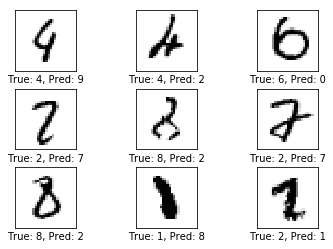

Confusion Matrix:
[[ 970    0    0    0    0    0    3    0    4    3]
 [   0 1125    4    0    0    0    2    3    1    0]
 [   0    1 1022    0    1    0    0    5    3    0]
 [   0    0    1 1001    0    2    0    3    2    1]
 [   0    0    1    0  958    0    1    2    2   18]
 [   2    0    0    4    0  881    2    0    2    1]
 [   4    2    0    1    1    4  946    0    0    0]
 [   0    0    6    0    0    0    0 1019    1    2]
 [   1    0    2    3    0    2    0    3  958    5]
 [   0    2    0    0    2    2    0    4    0  999]]


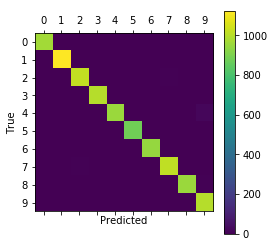

In [39]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Optimizing the Input Images

Now that the neural network has been optimized so it can recognize hand-written digits with about 99% accuracy, we will then find the input images that maximize certain features inside the neural network. This will show us what images the neural network *likes to see* the most.

We will do this by creating another form of optimization for the neural network, and we need several helper functions for doing this.

### Helper-function for getting the names of convolutional layers

Function for getting the names of all the convolutional layers in the neural network. We could have made this list manually, but for larger neural networks it is easier to do this with a function.

In [40]:
def get_conv_layer_names():
    graph = tf.get_default_graph()
    
    # Create a list of names for the operations in the graph
    # for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in graph.get_operations() if op.type=='Conv2D']

    return names

In [41]:
conv_names = get_conv_layer_names()

In [42]:
conv_names

['layer_conv1/Conv2D', 'layer_conv2/Conv2D']

In [43]:
len(conv_names)

2

### Helper-function for finding the input image

This function finds the input image that maximizes a given feature in the network. It essentially just performs optimization with gradient ascent. The image is initialized with small random values and is then iteratively updated using the gradient for the given feature with regard to the image.

In [44]:
def optimize_image(conv_id=None, feature=0,
                   num_iterations=30, show_progress=True):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last fully-connected layer
             before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    """

    # Create the loss-function that must be maximized.
    if conv_id is None:
        # If we want to maximize a feature on the last layer,
        # then we use the fully-connected layer prior to the
        # softmax-classifier. The feature no. is the class-number
        # and must be an integer between 1 and 1000.
        # The loss-function is just the value of that feature.
        loss = tf.reduce_mean(logits[:, feature])
    else:
        # If instead we want to maximize a feature of a
        # convolutional layer inside the neural network.

        # Get the name of the convolutional operator.
        conv_name = conv_names[conv_id]
        
        # Get the default TensorFlow graph.
        graph = tf.get_default_graph()
        
        # Get a reference to the tensor that is output by the
        # operator. Note that ":0" is added to the name for this.
        tensor = graph.get_tensor_by_name(conv_name + ":0")

        # The loss-function is the average of all the
        # tensor-values for the given feature. This
        # ensures that we generate the whole input image.
        # You can try and modify this so it only uses
        # a part of the tensor.
        loss = tf.reduce_mean(tensor[:,:,:,feature])

    # Get the gradient for the loss-function with regard to
    # the input image. This creates a mathematical
    # function for calculating the gradient.
    gradient = tf.gradients(loss, x_image)

    # Generate a random image of the same size as the raw input.
    # Each pixel is a small random value between 0.45 and 0.55,
    # which is the middle of the valid range between 0 and 1.
    image = 0.1 * np.random.uniform(size=img_shape) + 0.45

    # Perform a number of optimization iterations to find
    # the image that maximizes the loss-function.
    for i in range(num_iterations):
        # Reshape the array so it is a 4-rank tensor.
        img_reshaped = image[np.newaxis,:,:,np.newaxis]

        # Create a feed-dict for inputting the image to the graph.
        feed_dict = {x_image: img_reshaped}

        # Calculate the predicted class-scores,
        # as well as the gradient and the loss-value.
        pred, grad, loss_value = session.run([y_pred, gradient, loss],
                                             feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # input image in order to maximize the given feature.

        # Calculate the step-size for updating the image.
        # This step-size was found to give fast convergence.
        # The addition of 1e-8 is to protect from div-by-zero.
        step_size = 1.0 / (grad.std() + 1e-8)

        # Update the image by adding the scaled gradient
        # This is called gradient ascent.
        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        if show_progress:
            print("Iteration:", i)

            # Convert the predicted class-scores to a one-dim array.
            pred = np.squeeze(pred)

            # The predicted class for the Inception model.
            pred_cls = np.argmax(pred)

            # The score (probability) for the predicted class.
            cls_score = pred[pred_cls]

            # Print the predicted score etc.
            msg = "Predicted class: {0}, score: {1:>7.2%}"
            print(msg.format(pred_cls, cls_score))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Print the loss-value.
            print("Loss:", loss_value)

            # Newline.
            print()

    return image.squeeze()

This next function finds the images that maximize the first 10 features of a layer, by calling the above function 10 times.

In [45]:
def optimize_images(conv_id=None, num_iterations=30):
    """
    Find 10 images that maximize the 10 first features in the layer
    given by the conv_id.
    
    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last layer before the softmax output.
    num_iterations: Number of optimization iterations to perform.
    """

    # Which layer are we using?
    if conv_id is None:
        print("Final fully-connected layer before softmax.")
    else:
        print("Layer:", conv_names[conv_id])

    # Initialize the array of images.
    images = []

    # For each feature do the following.
    for feature in range(0,10):
        print("Optimizing image for feature no.", feature)
        
        # Find the image that maximizes the given feature
        # for the network layer identified by conv_id (or None).
        image = optimize_image(conv_id=conv_id, feature=feature,
                               show_progress=False,
                               num_iterations=num_iterations)

        # Squeeze the dim of the array.
        image = image.squeeze()

        # Append to the list of images.
        images.append(image)

    # Convert to numpy-array so we can index all dimensions easily.
    images = np.array(images)

    # Plot the images.
    plot_images10(images=images)

### First Convolutional Layer

These are the input images that maximize the features in the first convolutional layer, so these are the images that it *likes to see*.

Layer: layer_conv1/Conv2D
Optimizing image for feature no. 0
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6
Optimizing image for feature no. 7
Optimizing image for feature no. 8
Optimizing image for feature no. 9


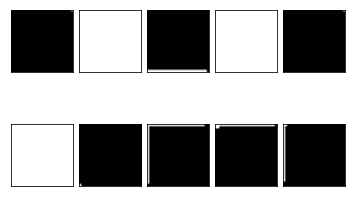

In [46]:
optimize_images(conv_id=0)

Note how these are very simple shapes such as lines and angles. Some of these images may be completely white, which suggests that those features of the neural network are perhaps unused, so the number of features could be reduced in this layer.

### Second Convolutional Layer

This shows the images that maximize the features or neurons in the second convolutional layer, so these are the input images it *likes to see*. Note how these are more complex lines and patterns compared to the first convolutional layer.

Layer: layer_conv2/Conv2D
Optimizing image for feature no. 0
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6
Optimizing image for feature no. 7
Optimizing image for feature no. 8
Optimizing image for feature no. 9


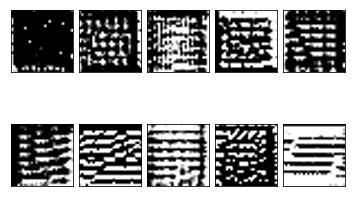

In [47]:
optimize_images(conv_id=1)

### Final output layer

Now find the image for the 2nd feature of the final output of the neural network. That is, we want to find an image that makes the neural network classify that image as the digit 2. This is the image that the neural network *likes to see the most* for the digit 2.

In [48]:
image = optimize_image(conv_id=None, feature=2,
                       num_iterations=10, show_progress=True)

Iteration: 0
Predicted class: 1, score:  65.21%
Gradient min: -0.754999, max:  0.602095, stepsize:      5.48
Loss: -0.24191949

Iteration: 1
Predicted class: 2, score: 100.00%
Gradient min: -0.959483, max:  0.945845, stepsize:      3.74
Loss: 31.78731

Iteration: 2
Predicted class: 2, score: 100.00%
Gradient min: -0.698926, max:  0.681807, stepsize:      4.26
Loss: 49.426582

Iteration: 3
Predicted class: 2, score: 100.00%
Gradient min: -0.679672, max:  0.737549, stepsize:      4.47
Loss: 54.057976

Iteration: 4
Predicted class: 2, score: 100.00%
Gradient min: -0.624817, max:  0.728835, stepsize:      4.41
Loss: 59.83038

Iteration: 5
Predicted class: 2, score: 100.00%
Gradient min: -0.617483, max:  0.689194, stepsize:      4.47
Loss: 58.287357

Iteration: 6
Predicted class: 2, score: 100.00%
Gradient min: -0.678464, max:  0.716904, stepsize:      4.35
Loss: 61.191967

Iteration: 7
Predicted class: 2, score: 100.00%
Gradient min: -0.649330, max:  0.682045, stepsize:      4.37
Loss: 59.

Note how the predicted class indeed becomes 2 already within the first few iterations so the optimization is working as intended. Also note how the loss-measure is increasing rapidly until it apparently converges. This is because the loss-measure is actually just the value of the feature or neuron that we are trying to maximize. Because this is the logits-layer prior to the softmax, these values can potentially be infinitely high, but they are limited because we limit the image-values between 0 and 1.

Now plot the image that was found. This is the image that the neural network believes looks most like the digit 2.

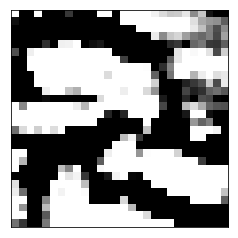

In [49]:
plot_image(image)

Although some of the curves do hint somewhat at the digit 2, it is hard for a human to see why the neural network believes this is the *optimal* image for the digit 2. This can only be understood when the optimal images for the remaining digits are also shown.

Final fully-connected layer before softmax.
Optimizing image for feature no. 0
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6
Optimizing image for feature no. 7
Optimizing image for feature no. 8
Optimizing image for feature no. 9


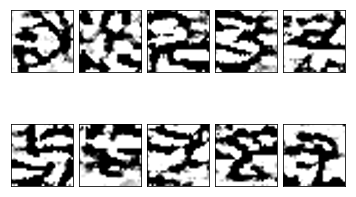

In [50]:
optimize_images(conv_id=None)

These images may vary each time you run the optimization. Some of the images can be seen to somewhat resemble the hand-written digits. But the other images are often impossible to recognize and it is hard to understand why the neural network thinks these are the *optimal* input images for those digits.

The reason is perhaps that the neural network tries to recognize all digits simultaneously, and it has found that certain pixels often determine whether the image shows one digit or another. So the neural network has learned to differentiate those pixels that it has found to be important, but not the underlying curves and shapes of the digits, in the same way that a human recognizes the digits.

Another possibility is that the data-set contains mis-classified digits which may confuse the neural network during training. We have previously seen how some of the digits in the data-set are very hard to read even for humans, and this may cause the neural network to become distorted and trying to recognize strange artifacts in the images.

Yet another possibility is that the optimization process has stagnated in a local optimum. One way to test this, would be to run the optimization 50 times for the digits that are unclear, and see if some of the resulting images become more clear.

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [51]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

This tutorial showed how to find the input images that maximize certain features inside a neural network. These are the images that the neural network *likes to see the most* in order to activate a certain feature or neuron inside the network.

This was tested on a simple convolutional neural network using the MNIST data-set. The neural network had clearly learned to recognize the general shape of some of the digits, while it was impossible to see how it recognized other digits.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Plot the images for all features in each convolutional layer instead of just the first 10 features. How many of them appear to be unused or redundant? What happens if you lower the number of features in that layer and train the network again, does it still perform just as well?

* Try adding more convolutional layers and find the input images that maximize their features. What do the images show? Do you think it is useful to add more convolutional layers than two?

* Try adding more fully-connected layers and modify the code so it can find input images that maximize the features of the fully-connected / dense layers as well. Currently the code can only maximize the features of the convolutional layers and the final fully-connected layer.

* For the input images that are unclear, run the optimization e.g. 50 times for each of those digits, to see if it produces more clear input images. It is possible that the optimization has simply become stuck in a local optimum.

* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.